In [1]:
import os
import glob
from functools import reduce

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Configurations

```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 2000,
        "num-calls": 1,
        "rate": 20,
        "ramp": 20,
        "iters": 50,
        "timeout": 1
    }
}
```

In [3]:
run_name = "current/httperf_balance_wrr_to1_percentiles"

## Client side stats

In [4]:
# read in the data
plot_data_list = []

for i in glob.glob("./results/" + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [5]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        if not i.startswith('Response time'):
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
        else:
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                       for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,1.0000,0,320.0,1.000,4.4375,304.0,304.0,0.81875,32000,306.0,...,318.0,2.6875,320.0,1.1875,0,32000,1.0000,304.0,320,311.0
1,1.0000,0,630.0,1.000,4.3125,624.0,624.0,0.88750,32000,624.0,...,630.0,3.1875,640.0,1.0000,0,32000,1.0000,624.0,640,624.0
2,1.0000,0,958.0,1.000,9.4375,944.0,944.0,1.46250,32000,946.0,...,958.0,7.6250,960.0,3.2500,0,32000,1.0000,944.0,960,948.0
3,2.6250,0,1277.0,1.000,17.2500,1264.0,1264.0,3.11875,32000,1268.0,...,1277.0,12.4375,1280.0,6.6875,0,32000,4.3750,1264.0,1280,1271.0
4,2.9375,0,1601.0,1.375,12.6875,1584.0,1584.0,3.18125,32000,1595.0,...,1601.0,10.8750,1600.0,6.8750,0,32000,4.5625,1584.0,1600,1601.0


### 1. Request rate

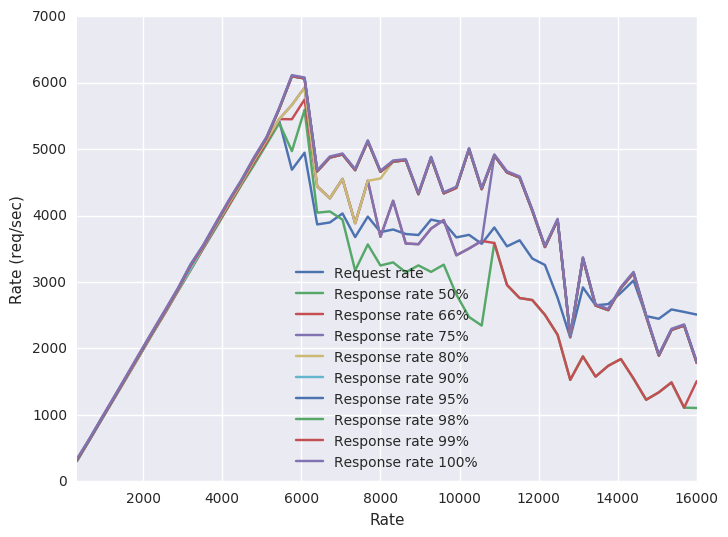

In [6]:
plot_data.plot('Rate', ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                        'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                        'Response rate 99%', 'Response rate 100%'], ylim=(0, None)).set_ylabel("Rate (req/sec)")

In [7]:
plot_data['Rate'].describe()

count       50.000000
mean      8160.000000
std       4664.761516
min        320.000000
25%       4240.000000
50%       8160.000000
75%      12080.000000
max      16000.000000
Name: Rate, dtype: float64

In [8]:
plot_data['Request rate'].describe()

count      50.000000
mean     3219.602000
std      1098.124883
min       320.000000
25%      2566.425000
50%      3527.150000
75%      3859.500000
max      5423.700000
Name: Request rate, dtype: float64

In [9]:
plot_data['Response rate 95%'].describe()

count      50.000000
mean     3616.180000
std      1440.944754
min       311.000000
25%      2506.000000
50%      4005.000000
75%      4781.750000
max      6099.000000
Name: Response rate 95%, dtype: float64

### 2. Response time

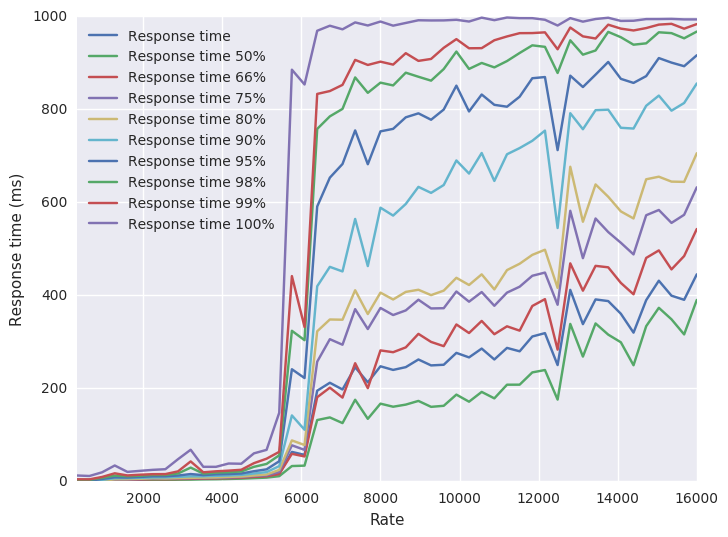

In [10]:
plot_data.plot('Rate', ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                        'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                        'Response time 99%', 'Response time 100%'], ylim=(0, None)).set_ylabel("Response time (ms)")

In [11]:
plot_data['Response time'].describe()

count     50.000000
mean     191.515375
std      153.888882
min        0.818750
25%        7.137500
50%      245.437500
75%      305.339063
max      445.181250
Name: Response time, dtype: float64

In [12]:
plot_data['Response time 95%'].describe()

count     50.000000
mean     516.087500
std      386.636434
min        1.250000
25%       15.984375
50%      753.656250
75%      850.187500
max      916.250000
Name: Response time 95%, dtype: float64

### 3. Success rate

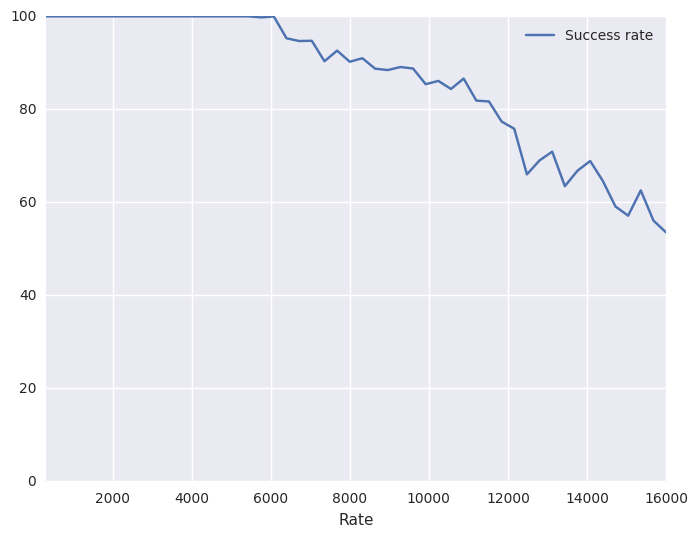

In [13]:
plot_data['Success rate'] = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
plot_data.plot('Rate', 'Success rate', ylim=(0, None))

In [14]:
plot_data['Success rate'].describe()

count     50.000000
mean      86.422323
std       14.912808
min       53.526916
25%       76.212068
50%       90.289889
75%      100.000000
max      100.000000
Name: Success rate, dtype: float64

## Server side stats

In [16]:
# read in the stats data
stats_data = pd.read_csv("./results/" + run_name + "/httperf_server_stats.csv", header=0, na_filter=False)
stats_data['Connections Ratio (%)'] = stats_data['Connections'] / sum(stats_data['Connections']) * 100
stats_data['Packets Ratio (%)'] = stats_data['Packets'] / sum(stats_data['Packets']) * 100
stats_data['Bytes Ratio (%)'] = stats_data['Bytes (K)'] / sum(stats_data['Bytes (K)']) * 100
stats_data

,Server,Connections,Packets,Bytes (K),Connections Ratio (%),Packets Ratio (%),Bytes Ratio (%)
0,11.11.11.107:80,14606,1557516,103490,25.0,25.157400,25.158502
1,11.11.11.106:80,14606,1557447,103594,25.0,25.156285,25.183784
2,11.11.11.103:80,14606,1541715,102426,25.0,24.902178,24.899842
3,11.11.11.102:80,14606,1534407,101842,25.0,24.784137,24.757872
